# RNA World Hypothesis

RNA is a simpler cousin of DNA.  As you may know, RNA is widely thought to be the first self replicating life-form to arise perhaps around 4 billion years ago. One of the strongest arguments for this theory is that RNA is able to carry information in its nucleotides like DNA, and like protein, it is able to adopt higher order structures to catalyze reactions, such as self replication. So it is likely, and there is growing evidence that this is the case, that the first form of replicating life was RNA. And because of this dual property of RNA as a hereditary information vessel as well as a structural/functional element we can use RNA molecules to build very nice population models. 

So in this section, we'll be walking you through building genetic populations, simulating their evolution, and using statistics and other mathematical tools for understanding key properties of populations.

In [1]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/K1xnYFCZ9Yg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/leo/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [2]:
#HTML('<iframe width="784" height="441" src="https://scaleofuniverse.com/" /iframe>')

## Population Evolution in *an* RNA World

In order to study the evolution of a population, we first need a model of a population. And even before that, we need to define what we mean by *population*. Populations can be defined on many levels and with many diffferent criteria. For our purposes, we will simply say that a population is a set of individuals sharing a common environment. And because this is population *genetics* we can think of individuals as entities comprising of specific genes or chromosomes. 

So where do we get a population from? As you may have discussed in previous workshops, there are very large datasets containing sequencing information from different populations. So we could download one of these datasets and perform some analysis on it. But I find this can be dry and tedious. So why download data when we can simply create our own?

In this section we're going to be creating and studying our own "artificial" populations to illustrate some important population genetics concepts and methodologies. Not only will this help you learn population genetics, but you will get a lot more programming practice than if we were to simply parse data files and go from there. 

More specifically, we're going to build our own RNA world.

### Building an RNA population

As we saw earlier, RNA has the nice property of posessing a strong mapping between information carrying (sequence) and function (structure). This is analogous to what is known in evolutionary terms as a genotype and a phenotype. With these properties, we have everything we need to model a population, and simulate its evolution.

#### RNA sequence-structure

We can think of the genotype as a sequence $s$ consisting of letters/nucleotides from the alphabet $\{U,A,C,G\}$. The corresponding phenotype $\omega$ is the secondary structure of $s$ which can be thought of as a pairing between nucleotides in the primary sequence that give rise to a 2D architecture. Because it has been shown that the function of many biomolecules, including RNA, is driven by structure this gives us a good proxy for phenotype. 

Below is an example of what an RNA secondary structure, or pairing, looks like.

In [3]:
### 1

from IPython.display import Image
#This will load an image of an RNA secondary structure
Image(url='https://viennarna.github.io/forgi/_images/1y26_ss.png')


In [4]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/JQByjprj_mA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')
#import matplotlib.pyplot as plt
#import forgi.visual.mplotlib as fvm
#import forgi
#cg = forgi.load_rna("1y26.fx", allow_many=False)
#fvm.plot_rna(cg, text_kwargs={"fontweight":"black"}, lighten=0.7,
#             backbone_kwargs={"linewidth":3})
#plt.show()

As you can see, unpaired positions are forming loop-like structures, and paired positions are forming stem-like structures. It is this spatial arrangement of nucleotides that drives RNA's function. Therefore, another sequence that adopts a similar shape, is likely to behave in a similar manner. Another thing to notice is that, although in reality this is often not the case, in general we only allow pairs between $\{C,G\}$ and $\{A, U\}$ nucleotides, most modern approaches allow for non-canonical pairings and you will find some examples of this in the above structure.

*How do we go from a sequence to a structure?*

So a secondary structure is just a list of pairings between positions. How do we get the optimal pairing?

The algorithm we're going to be using in our simulations is known as the Nussinov Algorithm. The Nussinov algorithm is one of the first and simplest attempts at predicting RNA structure. Because bonds tend to stabilize RNA, the algorithm tries to maximize the number of pairs in the structure and return that as its solution. Current approaches achieve more accurate solutions by using energy models based one experimental values to then obtain a structure that minimizes free energy. But since we're not really concerned with the accuracy of our predictions, Nussinov is a good entry point. Furthermore, the main algorithmic concepts are the same between Nussinov and state of the art RNA structure prediction algorithms. I implemented the algorithm in a separate file called `fold.py` that we can import and use its functions. I'm not going to go into detail here on how the algorithm works because it is beyond the scope of this workshop but there is a bonus exercise at the end if you're curious.

You can predict a secondary structure by calling `nussinov()` with a sequence string and it will return a tuple in the form `(structure, pairs)`.

In [5]:
### 2
import numpy as np
from fold import nussinov #Codes by Carlos G. Oliver (https://github.com/cgoliver)

sequence_to_fold = "ACCCGAUGUUAUAUAUACCU"
struc = nussinov(sequence_to_fold)
print(">test") #creates the structure of a .fx file for "forna"
print(sequence_to_fold)
print(struc[0])
#Check the molecule at: http://rna.tbi.univie.ac.at/forna/
# Paste the text below in the webpage and see the structure
#>test
#ACCCGAUGUUAUAUAUACCU
#(...(..(((....).))))

>test
ACCCGAUGUUAUAUAUACCU
(...(..(((....).))))


You will see a funny dot-bracket string in the output. This is a representation of the structure of an RNA. Quite simply, a matching parir of parentheses (open and close) correspond to the nucleotides at those positions being paried. Whereas, a dot means that that position is unpaired in the structure. Feel free to play around with the input sequence to get a better understanding of the notation.

If you want to visually check the sequence, go to: [forna](http://rna.tbi.univie.ac.at/forna/forna.html) and copy the text above with the sequence and its structure in the **Add Molecule** button.  The webpage is embedded below.

So that's enough about RNA structure prediction. Let's move on to building our populations.

In [6]:
HTML('<iframe width="784" height="441" src="http://rna.tbi.univie.ac.at/forna/forna.html" /iframe>')

In [7]:
print(np.random.choice(5, 3, p=[0.1, 0, 0.6, 0.3, 0],replace=True))

[3 0 2]


### Fitness of a sequence: Target Structure

Now that we have a good way of getting a phenotype (secondary structure), we need a way to evaluate the fitness of that phenotype. If we think in real life terms, fitness is the ability of a genotype to replicate into the next generation. If you have a gene carrying a mutation that causes some kind of disease, your fitness is decreased and you have a lower chance of contributing offspring to the next generation. On a molecular level the same concept applies. A molecule needs to accomplish a certain function, i.e. bind to some other molecule or send some kind of signal. And as we've seen before, the most important factor that determines how well it can carry out this function is its structure. So we can imagine that a certain structure, we can call this a 'target' structure, is required in order to accomplish a certain function. So a sequence that folds correctly to a target structure is seen as having a greater fitness than one that does not. Since we've encoded structures as simple dot-bracket strings, we can easily compare structures and thus evaluate the fitness between a given structure and the target, or 'correct' structure. 

There are many ways to compare structures $w_{1}$ and $w_{2}$, but we're going to use one of the simplest ways, which is base-pair distance. This is just the number of pairs in $w_{1}$ that are not in $w_{2}$. Again, this is beyond the scope of this workshop so I'll just give you the code for it and if you would like to know more you can ask me.

In [8]:
### 3

#ss_to_bp() and bp_distance() by Vladimir Reinharz.
def ss_to_bp(ss):
    bps = set()
    l = []
    for i, x in enumerate(ss):
            if x == '(':
                    l.append(i)
            elif x == ')':
                    bps.add((l.pop(), i))
    return bps

def bp_distance(w1, w2):
    """
    return base pair distance between structures w1 and w1. 
    w1 and w1 are lists of tuples representing pairing indices.
    """
    return len(set(w1).symmetric_difference(set(w2)))

#let's fold two sequences
w1 = nussinov("CCAAAAGG")
w2 = nussinov("ACAAAAGA")

print(w1)
print(w2)

#give the list of pairs to bp_distance and see what the distance is.
print(bp_distance(w1[-1], w2[-1]))

('((....))', [(0, 7), (1, 6)])
('.(....).', [(1, 6)])
1


## Defining a cell

The cell we will define here is a simple organism with two copies of an RNA gene, each with its own structure.  This simple definition of a cell will help us create populations to play around in our evolutionary reactor.

In [9]:
### 4
class Cell:
    def __init__(self, seq_1, struc_1, seq_2, struc_2):
        self.sequence_1 = seq_1
        self.sequence_2 = seq_2
        self.structure_1 = struc_1
        self.structure_2 = struc_2
        
#for now just try initializing a Cell with made up sequences and structures
cell = Cell("AACCCCUU", "((.....))", "GGAAAACA", "(....).")
print(cell.sequence_1, cell.structure_2, cell.sequence_1, cell.structure_2)

AACCCCUU (....). AACCCCUU (....).


## Populations of Cells

Now we've defined a 'Cell'. Since a population is a collection of individuals our populations will naturally consist of **lists** of 'Cell' objects, each with their own sequences. Here we initialize all the Cells with random sequences and add them to the 'population' list.

In [10]:
### 5
import random

def populate(target, pop_size):
    '''Creates a population of cells (pop_size) with a number of random RNA nucleotides (AUCG)
    matching the length of the target structure'''
    population = []

    for i in range(pop_size):
        #get a random sequence to start with
        sequence = "".join([random.choice("AUCG") for _ in range(len(target))])
        #use nussinov to get the secondary structure for the sequence
        structure = nussinov(sequence)
        #add a new Cell object to the population list
        new_cell = Cell(sequence, structure, sequence, structure)
        new_cell.id = i
        new_cell.parent = i
        population.append(new_cell)
            
    return population

Try creating a new population and printing the first 10 sequences and structures (in dot-bracket) on the first chromosome!

In [11]:
### 6
target = "(((....)))"
pop = populate(target, pop_size=300)
for p in pop[:10]:
    print(p.id, p.sequence_1, p.structure_1[0], p.sequence_2, p.structure_2[0])
    
for p in pop[-10:]:#for p in pop[:10]:#for p in pop[-10:]:#for p in pop[:10]:
    print(p.id, p.sequence_1, p.structure_1[0], p.sequence_2, p.structure_2[0])

0 AUACCUGCGC (....).... AUACCUGCGC (....)....
1 GAGACGAUAG .(.....).. GAGACGAUAG .(.....)..
2 AUUUUUUAGC (....).... AUUUUUUAGC (....)....
3 ACACAUCGUU ((.....)). ACACAUCGUU ((.....)).
4 CCACGGCCGU ..((....)) CCACGGCCGU ..((....))
5 GAAUCUGUGG .(.....).. GAAUCUGUGG .(.....)..
6 UUCAUCACUA ((....)..) UUCAUCACUA ((....)..)
7 CUCUGAUUCC ....(....) CUCUGAUUCC ....(....)
8 GACAAGCACC (.....)... GACAAGCACC (.....)...
9 CCCCACUCCG (........) CCCCACUCCG (........)
290 GGUCGCACGG (....).... GGUCGCACGG (....)....
291 GGAGUGUUUU ..(....).. GGAGUGUUUU ..(....)..
292 GAACCACGCG (.....)... GAACCACGCG (.....)...
293 GCCCCGGCUC ((....)).. GCCCCGGCUC ((....))..
294 CGUCACCACA .((....)). CGUCACCACA .((....)).
295 UCAGCUCCUC ..(.....). UCAGCUCCUC ..(.....).
296 CGGAGGCAAA (....).... CGGAGGCAAA (....)....
297 AGUCCUUGGC .(.(....)) AGUCCUUGGC .(.(....))
298 UUGGUUUUUA (........) UUGGUUUUUA (........)
299 ACGCGUUCAA (....).... ACGCGUUCAA (....)....


## The Fitness of a Cell 


Once we are able to create populations of cells, we need a way of asssessing their individual fitness.  In our model, a *Cell* is an object that contains two sequences of RNA, something analogous to having two copies of a gene in each chromosome.   

We could simply loop through each *Cell* in the population and check the base pair distance to the target structure we defined.  However, this approach of using base-pair distance is not the best for defining fitness. There are two reasons for this: 

1. We want fitness to represent a *probability* that a cell will reproduce (pass its genes to the next generation), and base pair distance is, in our case, an integer value.
2. We want this probability to be a *relative* measure of fitness. That is, we want the fitness to be proportional to how good a cell is with respect to all others in the population. This touches on an important principle in evolution where we only need to be 'better' than the rest of the population (the competition) and not good in some absolute measure. For instance, if you and I are being chased by a predator. In order to survive, I only need to be faster than you, and not necessarily some absolute level of fitness.

In order to get a probability (number between 0 and 1) we use the following equation to define the fitness of a structure $\omega$ on a target structure $T$:

$$P(\omega, T) = N^{-1} exp(\frac{-\beta \texttt{dist}(\omega, T)}{\texttt{len}(\omega)})$$

$$N = \sum_{i \in Pop}{P(\omega_i, T})$$

Here, the $N$ is what gives us the 'relative' measure because we divide the fitness of the Cell by the sum of the fitness of every other Cell. 

Let's take a quick look at how this function behaves if we plot different base pair distance values.

What is the effect of the parameter $\beta$? Try plotting the same function but with different values of $\beta$.

Text(0, 0.5, 'P(w, T)')

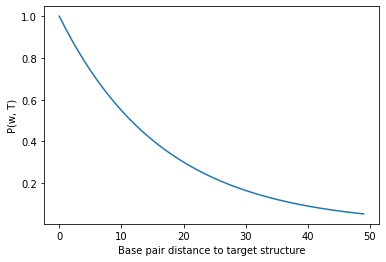

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

target_length = 50
beta = -3

plt.plot([math.exp(beta * (bp_dist / float(target_length))) for bp_dist in range(target_length)])
plt.xlabel("Base pair distance to target structure")
plt.ylabel("P(w, T)")

As you can see, it's a very simple function that evaluates to 1 (highest fitness) if the base pair distance is 0, and decreases as the structures get further and further away from the target. I didn't include the $N$ in the plotting as it will be a bit more annoying to compute, but it is simply a scaling factor so the shape and main idea won't be different.

Now we can use this function to get a fitness value for each Cell in our population.

In [13]:
### 7

def compute_fitness(population, target, beta=-3):
    """
    Assigns a fitness and bp_distance value to each cell in the population.
    """
    #store the fitness values of each cell
    tot = []
    #iterate through each cell
    for cell in population:
        
        #calculate the bp_distance of each chromosome using the cell's structure
        bp_distance_1 = bp_distance(cell.structure_1[-1], ss_to_bp(target))
        bp_distance_2 = bp_distance(cell.structure_2[-1], ss_to_bp(target))
        
        #use the bp_distances and the above fitness equation to calculate the fitness of each chromosome
        fitness_1 = math.exp((beta * bp_distance_1 / float(len(cell.sequence_1))))
        fitness_2 =  math.exp((beta * bp_distance_2 / float(len(cell.sequence_2))))

        #get the fitness of the whole cell by multiplying the fitnesses of each chromosome
        cell.fitness = fitness_1 * fitness_2
               
        #store the bp_distance of each chromosome.
        cell.bp_distance_1 = bp_distance_1
        cell.bp_distance_2 = bp_distance_2
    
        
        #add the cell's fitness value to the list of all fitness values (used for normalization later)
        tot.append(cell.fitness)

    #normalization factor is sum of all fitness values in population
    norm = np.sum(tot)
    #divide all fitness values by the normalization factor.
    for cell in population:
        cell.fitness = cell.fitness / norm

    return None

compute_fitness(pop, target)
for cell in pop[:10]:
    print(cell.fitness, cell.bp_distance_1, cell.bp_distance_2)

0.002062018587047619 4 4
0.002062018587047619 4 4
0.002062018587047619 4 4
0.001131659794413896 5 5
0.001131659794413896 5 5
0.002062018587047619 4 4
0.0037572428342141384 3 3
0.002062018587047619 4 4
0.002062018587047619 4 4
0.006846142805854101 2 2


## Introducing diversity: Mutations

Evolution would go nowhere without random mutations. While mutations are technically just random errors in the copying of genetic material, they are essential in the process of evolution. This is because they introduce novel diversity to populatons, which with a low frequency can be beneficial. And when a beneficial mutation arises (i.e. a mutation that increases fitness, or replication probability) it quickly takes over the population and the populatioin as a whole has a higher fitness.

Implementing mutations in our model will be quite straightforward. Since mutations happen at the genotype/sequence level, we simply have to iterate through our strings of nucleotides (sequences) and randomly introduce changes.

In [14]:
def mutate(sequence, mutation_rate=0.001):
    """Takes a sequence and mutates bases with probability mutation_rate"""
    
    #start an empty string to store the mutated sequence
    new_sequence = ""
    #boolean storing whether or not the sequence got mutated
    mutated = False
    #go through every bp in the sequence
    for bp in sequence:
        #generate a random number between 0 and 1
        r = random.random()
        #if r is below mutation rate, introduce a mutation
        if r < mutation_rate:
            #add a randomly sampled nucleotide to the new sequence
            new_sequence = new_sequence + random.choice("aucg")
            mutated = True
        else:
            #if the mutation condition did not get met, copy the current bp to the new sequence
            new_sequence = new_sequence + bp
            
    return (new_sequence, mutated)

sequence_to_mutate = 'AAAAGGAGUGUGUAUGU'
print(sequence_to_mutate)
print(mutate(sequence_to_mutate, mutation_rate=0.5))

AAAAGGAGUGUGUAUGU
('gAgAGGaGuGUgUaUGU', True)


## Selection

The final process in this evolution model is selection. Once you have populations with a diverse range of fitnesses, we need to select the fittest individuals and let them replicate and contribute offspring to the next generation. In real populations this is just the process of reproduction. If you're fit enough you will be likely to reproduce more than another individual who is not as well suited to the environment.

In order to represent this process in our model, we will use the fitness values that we assigned to each Cell earlier and use that to select replicating Cells. This is equivalent to sampling from a population with the sampling being weighted by the fitness of each Cell. Thankfully, `numpy.random.choice` comes to the rescue here. Once we have sampled enough Cells to build our next generation, we introduce mutations and compute the fitness values of the new generation.

In [15]:
def selection(population, target, mutation_rate=0.001, beta=-3):
    """
    Returns a new population with offspring of the input population
    """

    #select the sequences that will be 'parents' and contribute to the next generation
    parents = np.random.choice(population, len(population), p=[rna.fitness for rna in population], replace=True)

    #build the next generation using the parents list
    next_generation = []    
    for i, p in enumerate(parents):
        new_cell = Cell(p.sequence_1, p.structure_1, p.sequence_2, p.structure_2)
        new_cell.id = i
        new_cell.parent = p.id
        
        next_generation.append(new_cell)

    #introduce mutations in next_generation sequeneces and re-fold when a mutation occurs
    for rna in next_generation:      
        mutated_sequence_1, mutated_1 = mutate(rna.sequence_1, mutation_rate=mutation_rate)
        mutated_sequence_2, mutated_2 = mutate(rna.sequence_2, mutation_rate=mutation_rate)
        
        if mutated_1:
            rna.sequence_1 = mutated_sequence_1
            rna.structure_1 = nussinov(mutated_sequence_1)
        if mutated_2:
            rna.sequence_2 = mutated_sequence_2
            rna.structure_2 = nussinov(mutated_sequence_2)
        else:
            continue

    #update fitness values for the new generation
    compute_fitness(next_generation, target, beta=beta)

    return next_generation

next_gen = selection(pop, target)
for cell in next_gen[:10]:
    print(cell.sequence_1)

ACUUCAGAAU
AGGGCCUACG
GCAUAACGGA
CUCGCUACCG
CUAGUCGGUC
AAGGGAUGAC
AAAGAAUCAU
CUCUGAUUCC
CGCGGUUACG
AAGCUAGUAU


## Gathering information on our populations

Here we simply store some statistics (in a dictionary) on the population at each generation such as the average base pair distance and the average fitness of the populations. No coding to do here, it's not a very interesting function but feel free to give it a look.

In [16]:
def record_stats(pop, population_stats):
    """
    Takes a population list and a dictionary and updates it with stats on the population.
    """
    generation_bp_distance_1 = [rna.bp_distance_1 for rna in pop]
    generation_bp_distance_2 = [rna.bp_distance_2 for rna in pop]

    mean_bp_distance_1 = np.mean(generation_bp_distance_1)
    mean_bp_distance_2 = np.mean(generation_bp_distance_2)
    
    mean_fitness = np.mean([rna.fitness for rna in pop])


    population_stats.setdefault('mean_bp_distance_1', []).append(mean_bp_distance_1)
    population_stats.setdefault('mean_bp_distance_2', []).append(mean_bp_distance_2)
    
    population_stats.setdefault('mean_fitness', []).append(mean_fitness)
    
    return None

## And finally.... evolution

We can put all the above parts together in a simple function that does the following:

1. start a new population and compute its fitness
2. repeat the following for the desired number of generations:
    1. record statistics on population
    2. perform selection+mutation
    3. store new population

And that's it! We have an evolutionary reactor!

In [17]:
def evolve(target, generations=20, pop_size=100, mutation_rate=0.001, beta=-2):
    """
    Takes target structure and sets up initial population, performs selection and iterates for desired generations.
    """
    #store list of all populations throughotu generations [[cells from generation 1], [cells from gen. 2]...]
    populations = []
    #start a dictionary that will hold some stats on the populations.
    population_stats = {}
    
    #get a starting population
    initial_population = populate(target, pop_size=pop_size)
    #compute fitness of initial population
    compute_fitness(initial_population, target)

    #set current_generation to initial population.
    current_generation = initial_population

    #iterate the selection process over the desired number of generations
    for i in range(generations):

        #let's get some stats on the structures in the populations   
        record_stats(current_generation, population_stats)
        
        #add the current generation to our list of populations.
        populations.append(current_generation)

        #select the next generation
        new_gen = selection(current_generation, target, mutation_rate=mutation_rate, beta=beta)
        #set current generation to be the generation we just obtained.
        current_generation = new_gen 
    
    return (populations, population_stats)

Try a run of the `evolve()` function.

In [18]:
target = "(((....)))"
pops, pops_stats = evolve(target, generations=20, pop_size=300, mutation_rate=0.001, beta=-2)

#Print the first 10 sequences of the population
for p in pop[:10]:
    print(p.id, p.sequence_1, p.structure_1[0], p.sequence_2, p.structure_2[0])

#Print the last 10 sequences of the population    
for p in pop[-10:]:
    print(p.id, p.sequence_1, p.structure_1[0], p.sequence_2, p.structure_2[0])

0 AUACCUGCGC (....).... AUACCUGCGC (....)....
1 GAGACGAUAG .(.....).. GAGACGAUAG .(.....)..
2 AUUUUUUAGC (....).... AUUUUUUAGC (....)....
3 ACACAUCGUU ((.....)). ACACAUCGUU ((.....)).
4 CCACGGCCGU ..((....)) CCACGGCCGU ..((....))
5 GAAUCUGUGG .(.....).. GAAUCUGUGG .(.....)..
6 UUCAUCACUA ((....)..) UUCAUCACUA ((....)..)
7 CUCUGAUUCC ....(....) CUCUGAUUCC ....(....)
8 GACAAGCACC (.....)... GACAAGCACC (.....)...
9 CCCCACUCCG (........) CCCCACUCCG (........)
290 GGUCGCACGG (....).... GGUCGCACGG (....)....
291 GGAGUGUUUU ..(....).. GGAGUGUUUU ..(....)..
292 GAACCACGCG (.....)... GAACCACGCG (.....)...
293 GCCCCGGCUC ((....)).. GCCCCGGCUC ((....))..
294 CGUCACCACA .((....)). CGUCACCACA .((....)).
295 UCAGCUCCUC ..(.....). UCAGCUCCUC ..(.....).
296 CGGAGGCAAA (....).... CGGAGGCAAA (....)....
297 AGUCCUUGGC .(.(....)) AGUCCUUGGC .(.(....))
298 UUGGUUUUUA (........) UUGGUUUUUA (........)
299 ACGCGUUCAA (....).... ACGCGUUCAA (....)....


Let's see if it actually worked by plotting the average base pair distance as a function of generations for both genes in each cell. We should expect a gradual decrease as the populations get closer to the target structure.

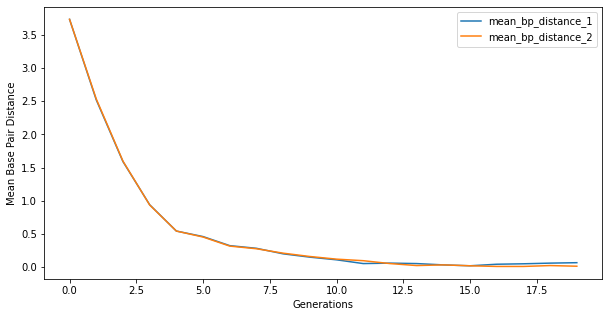

In [19]:
def evo_plot(pops_stats):
    """
    Plot base pair distance for each chromosome over generations.
    """
    plt.figure('Mean base pair Distance',figsize=(10,5))
    for m in ['mean_bp_distance_1', 'mean_bp_distance_2']:
        plt.plot(pops_stats[m], label=m)
    plt.legend()
    plt.xlabel("Generations")
    plt.ylabel("Mean Base Pair Distance")
    
evo_plot(pops_stats)

Let's see the structure of random cells from each generation.  Run the code below and copy the output in the RNA folding webpage. Compare the base-pair distance plot with the structures.

Questions:
- Do you notice some simmilarities from a particular generation onwards? Compare your observations to the plot with the Mean Base Pair Distance.
- What could trigger another evolutionary jump? 

![Structure of RNA](RNA_evolution.png)


In [20]:
from IPython.display import HTML
HTML('<iframe width="784" height="441" src="http://rna.tbi.univie.ac.at/forna/forna.html" /iframe>')

In [21]:
#Select a random RNA sequence from each generation to check its folding structure
from random import randrange
#print(randrange(999))
generations=20
pop_size=300
#Print some random cells from each generation 
#pops[generation][cell in that generation].{quality to retrieve}
for gen in range(0,generations):
    cid=randrange(pop_size)
    print('>Gen'+np.str(gen+1)+'_Cell_'+np.str(pops[gen][cid].id)+'')
    print(pops[gen][2].sequence_1)
    print(''+np.str(pops[gen][2].structure_1[0])+'\n')

>Gen1_Cell_200
GAACGAAAUU
.((.....))

>Gen2_Cell_53
AUAUGACUAC
.((....)).

>Gen3_Cell_186
CUGAUCGCAG
(((....)))

>Gen4_Cell_27
CGUGCAUACU
.((....)).

>Gen5_Cell_239
GACUGCCGUA
.((....)).

>Gen6_Cell_50
CUGAUCGCAG
(((....)))

>Gen7_Cell_118
CUGAUCGCAG
(((....)))

>Gen8_Cell_257
AGAAACGUCU
(((....)))

>Gen9_Cell_252
GGAUAUGUCC
(((....)))

>Gen10_Cell_208
GGAUAUGUCC
(((....)))

>Gen11_Cell_70
AGAAACGUCU
(((....)))

>Gen12_Cell_95
CUGAUCGCAG
(((....)))

>Gen13_Cell_227
AcCGCAAUGU
(.(.....))

>Gen14_Cell_183
CUGAUCGCAG
(((....)))

>Gen15_Cell_55
GGAUAUGUCC
(((....)))

>Gen16_Cell_89
AUAUGGAUAU
(((....)))

>Gen17_Cell_175
CUGAUCGCAG
(((....)))

>Gen18_Cell_163
CUGAUCGCAG
(((....)))

>Gen19_Cell_48
AUAUGGAUAU
(((....)))

>Gen20_Cell_244
CUGAUCGCAG
(((....)))



You should see a nice drop in base pair distance! Another way of visualizing this is by plotting a histogram of the base pair distance of all Cells in the initial population versus the final population.

In [22]:
#import seaborn as sns
#def bp_distance_distributions(pops):
#    """
#    Plots histograms of base pair distance in initial and final populations.
#    """
#    #plot bp_distance_1 for rnas in first population
#   g = sns.distplot([rna.bp_distance_1 for rna in pops[0]], label='initial population')
#    #plot bp_distance_1 for rnas in first population
#    g = sns.distplot([rna.bp_distance_1 for rna in pops[-1]], label='final population')
#    g.set(xlabel='Mean Base Pair Distance')
#    g.legend()
#
#bp_distance_distributions(pops)

## Introducing mating to the model

The populations we generated evolved asexually. This means that individuals do not mate or exchange genetic information. So to make our simulation a bit more interesting let's let the Cells mate. This is going to require a few small changes in the `selection()` function. Previously, when we selected sequences to go into the next generation we just let them provide one offspring which was a copy of itself and introduced mutations. Now instead of choosing one Cell at a time, we will randomly choose two 'parents' that will mate. When they mate, each parent will contribute one of its chromosomes to the child. We'll repeat this process until we have filled the next generation.

In [23]:
def selection_with_mating(population, target, mutation_rate=0.001, beta=-2):
    next_generation = []
    
    counter = 0
    while len(next_generation) < len(population):
        #select two parents based on their fitness
        parents_pair = np.random.choice(population, 2, p=[rna.fitness for rna in population], replace=False)
        
        #take the sequence and structure from the first parent's first chromosome and give it to the child
        child_chrom_1 = (parents_pair[0].sequence_1, parents_pair[0].structure_1)

        #do the same for the child's second chromosome and the second parent.
        child_chrom_2 = (parents_pair[1].sequence_2, parents_pair[1].structure_2)


        #initialize the new child Cell with the new chromosomes.
        child_cell = Cell(child_chrom_1[0], child_chrom_1[1], child_chrom_2[0], child_chrom_2[1])

        #give the child and id and store who its parents are
        child_cell.id = counter
        child_cell.parent_1 = parents_pair[0].id
        child_cell.parent_2 = parents_pair[1].id

        #add the child to the new generation
        next_generation.append(child_cell)
        
        counter = counter + 1
            
        
    #introduce mutations in next_generation sequeneces and re-fold when a mutation occurs (same as before)
    for rna in next_generation:      
        mutated_sequence_1, mutated_1 = mutate(rna.sequence_1, mutation_rate=mutation_rate)
        mutated_sequence_2, mutated_2 = mutate(rna.sequence_2, mutation_rate=mutation_rate)

        if mutated_1:
            rna.sequence_1 = mutated_sequence_1
            rna.structure_1 = nussinov(mutated_sequence_1)
        if mutated_2:
            rna.sequence_2 = mutated_sequence_2
            rna.structure_2 = nussinov(mutated_sequence_2)
        else:
            continue

    #update fitness values for the new generation
    compute_fitness(next_generation, target, beta=beta)

    return next_generation    

#run a small test to make sure it works
next_gen = selection_with_mating(pop, target)
for cell in next_gen[:10]:
    print(cell.sequence_1)

CAGGGUUGGC
UUCCCUUUCU
UAGUGCGCUC
AUACAAGUAC
CUCUGAUUCC
CGAGGCAACU
CGUCACCACA
UCCACGAGUU
UCUCCAAUAC
AAAUCCGAUU


Now we just have to update our `evolution()` function to call the new `selection_with_mating()` function.

In [24]:
def evolve_with_mating(target, generations=10, pop_size=100, mutation_rate=0.001, beta=-2):
    populations = []
    population_stats = {}
    
    initial_population = populate(target, pop_size=pop_size)
    compute_fitness(initial_population, target)
        
    current_generation = initial_population

    #iterate the selection process over the desired number of generations
    for i in range(generations):
        #let's get some stats on the structures in the populations   
        record_stats(current_generation, population_stats)
        
        #add the current generation to our list of populations.
        populations.append(current_generation)

        #select the next generation, but this time with mutations
        new_gen = selection_with_mating(current_generation, target, mutation_rate=mutation_rate, beta=beta)
        current_generation = new_gen 
    
    return (populations, population_stats)

Try out the new evolution model!

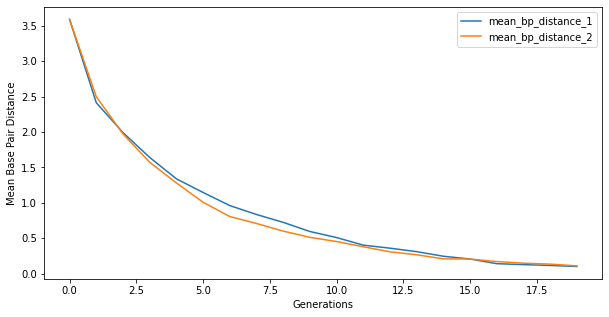

In [25]:
pops_mating, pops_stats_mating = evolve_with_mating("(((....)))", generations=20, pop_size=1000, beta=-2)

evo_plot(pops_stats_mating)

In [26]:
#Select a random RNA sequence from each generation to check its folding structure
from random import randrange
#print(randrange(999))
generations=20
pop_size=1000
#Print some random cells from each generation 
#pops[generation][cell in that generation].{quality to retrieve}
for gen in range(0,generations):
    cid=randrange(pop_size)
    print('>Gen'+np.str(gen+1)+'_Cell_'+np.str(pops_mating[gen][cid].id)+'')
    print(pops_mating[gen][2].sequence_1)
    print(''+np.str(pops_mating[gen][2].structure_1[0])+'\n')

>Gen1_Cell_118
GGGCUGGUGU
...(....).

>Gen2_Cell_263
GACUCAAAUC
((......))

>Gen3_Cell_259
CAGACCGAUG
((......))

>Gen4_Cell_877
AUGGCUGCUC
(.(....)).

>Gen5_Cell_710
GAUUCUCCAC
(.(.....))

>Gen6_Cell_207
GCGGCGAGUU
.(.....)..

>Gen7_Cell_947
GGAAAGGAAC
(........)

>Gen8_Cell_975
AUCCGCGGAC
.((....)).

>Gen9_Cell_747
ACUGACACGU
((......))

>Gen10_Cell_736
UCUUUUCCCU
..........

>Gen11_Cell_498
AGUCAGUAAU
(.(....).)

>Gen12_Cell_255
CACAACCGUU
.((....)).

>Gen13_Cell_458
GACUCAAAUC
((......))

>Gen14_Cell_280
UAAAAUGUUA
(((....)))

>Gen15_Cell_956
UACUUAUGUG
.((....)).

>Gen16_Cell_168
UUCGCUUGAA
(((....)))

>Gen17_Cell_242
CUUGAUCAAG
(((....)))

>Gen18_Cell_232
CCAACCAUGG
(((....)))

>Gen19_Cell_226
CAAUGACGUG
((......))

>Gen20_Cell_26
CCAACCAUGG
(((....)))



# Acknowledgements

The computational codes of this notebook were originally created by [Carlos G. Oliver](https://github.com/cgoliver), and adapted by Evert Durán for ASTRO200.